# Introduction

In this notebook, we will be investigating MIXUP Text Data Augmentation method by using simpletransformers via BERT.

# Import Necessary Packages

In [340]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import re # Regex
import string # String manipulation
import spacy # NLP tooling

# IMPORTS FOR TRAINING
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import  Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils import shuffle


#Preprocessing
from sklearn.preprocessing import LabelEncoder # Encode label into numerical format
from sklearn.model_selection import train_test_split # Split train and validation set

#RESULTS
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/emotion-detection-from-text/tweet_emotions.csv


# About Data

emotion-detection-from-text dataset has 40.000 samples with 13 classes. <br/>

* **sentiment**: includes 13 classes as follows, *class name : amount<br/>*
('neutral': 8638,<br/>
 'worry': 8459,<br/>
 'happiness': 5209,<br/>
 'sadness': 5165,<br/>
 'love': 3842,<br/>
 'surprise': 2187,<br/>
 'fun': 1776,<br/>
 'relief': 1526,<br/>
 'hate': 1323,<br/>
 'empty': 827,<br/>
 'enthusiasm': 759,<br/>
 'boredom': 179,<br/>
 'anger': 110 )<br/>
 <br/>
* **content**: includes text we will classify<br/>
* **tweet_id**: unique id

# Loading data & Preprocessing

In [341]:
nlp = spacy.load('en_core_web_sm')  
df_document = pd.read_csv('../input/emotion-detection-from-text/tweet_emotions.csv')

In [342]:
df_document

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...
...,...,...,...
39995,1753918954,neutral,@JohnLloydTaylor
39996,1753919001,love,Happy Mothers Day All my love
39997,1753919005,love,Happy Mother's Day to all the mommies out ther...
39998,1753919043,happiness,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...


In [343]:
def clean_text(text):
    regex_html = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    remove_digits = str.maketrans('', '', string.digits + string.punctuation)
    text = re.sub(regex_html, '', text)
    text = text.translate(remove_digits)
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", text).split()).lower()

df_document['text'] = (df_document.content).apply(clean_text)
#\.apply(nlp).apply(lambda x: " ".join(token.lemma_ for token in x if not token.is_stop).lower())

In [344]:
df_document

,tweet_id,sentiment,content,text
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...,tiffanylue i know i was listenin to bad habit ...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...,layin n bed with a headache ughhhhwaitin on yo...
2,1956967696,sadness,Funeral ceremony...gloomy friday...,funeral ceremonygloomy friday
3,1956967789,enthusiasm,wants to hang out with friends SOON!,wants to hang out with friends soon
4,1956968416,neutral,@dannycastillo We want to trade with someone w...,dannycastillo we want to trade with someone wh...
...,...,...,...,...
39995,1753918954,neutral,@JohnLloydTaylor,johnlloydtaylor
39996,1753919001,love,Happy Mothers Day All my love,happy mothers day all my love
39997,1753919005,love,Happy Mother's Day to all the mommies out ther...,happy mothers day to all the mommies out there...
39998,1753919043,happiness,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...,niariley wassup beautiful follow me peep out m...


# Visualization (EDA)
[referenced notebook for some EDA stuff](https://www.kaggle.com/pashupatigupta/starter-notebook-a-to-z-emotion-detection)

In [345]:
df_document.sentiment.value_counts()

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



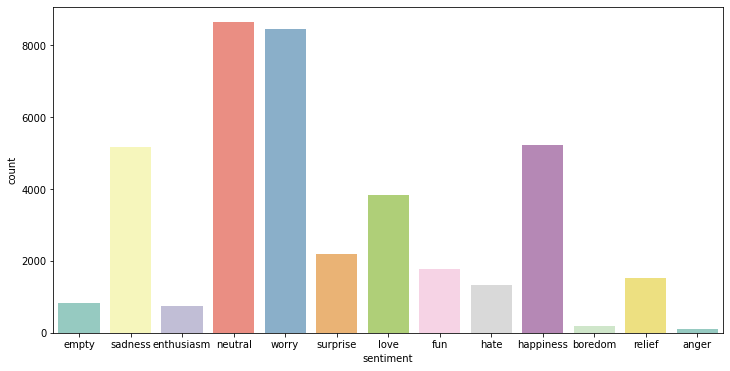

In [346]:
import seaborn as sns
countplt, ax = plt.subplots(figsize = (12,6))
ax = sns.countplot(df_document.sentiment, palette='Set3')

We used ***train.sentiment*** to look sentiments in graph, however, we will use corresponding numbers which we will create by labelencoder under ***train.label*** to use in training phase.

#### So we undertand from basic exploratory analysis, we have very imbalanced dataset. We can easily guess that the score will be really bad because the classes like boredom, anger and enthusiasm do not let the model learn properly. 

#### Our model will be prone to memorize neutral and worry because of their amount of samples. 
**Recap** <br/>
'empty': 827 <br/>
'enthusiasm': 759 <br/>
'boredom': 179 <br/>
'anger': 110 <br/>
'fun': 1776 <br/>
'surprise': 2187 <br/>
'relief' : 1526 <br/>

#### As a last pre-processing step we will remove 7 classes which are insufficient and use as 'other'. (boredom, anger, enthusiasm, fun, surprise, relief and empty)

#### We will continue with 7 classes because we will use removed ones as 'other' label.

#### *The reason we will remove specific classes.* <br />
#### Before work, I observed that some of classes have 0 scores due to lack of data amount and sentiment ambiguity. <br />
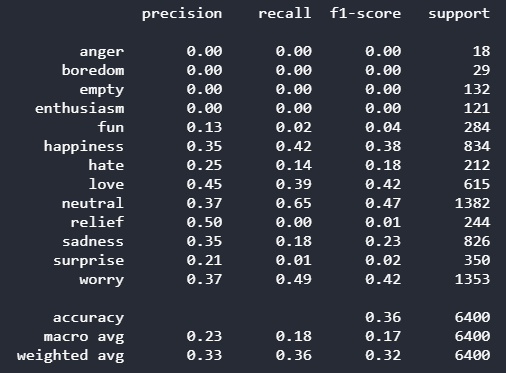


In [347]:
df_document['sentiment'] = df_document['sentiment'].apply(lambda x : x if x in ['happiness', 'sadness', 'worry', 'neutral', 'love', 'hate'] else 'other') 

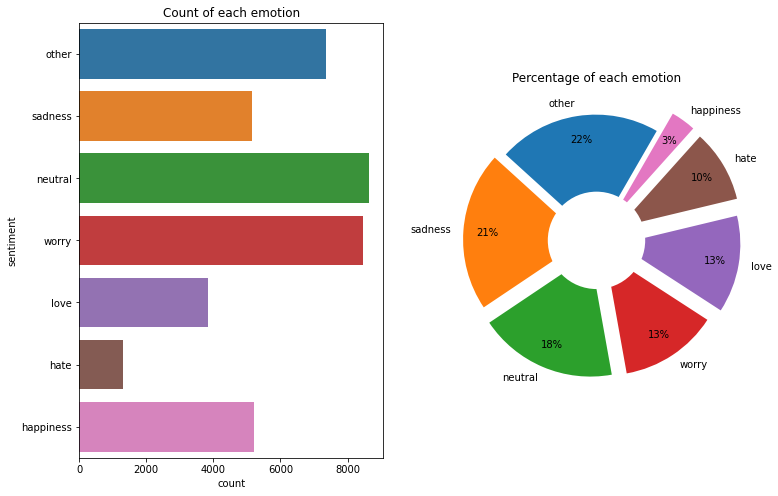

In [348]:
col = 'sentiment'
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
explode = list((np.array(list(df_document[col].dropna().value_counts()))/sum(list(df_document[col].dropna().value_counts())))[::-1])[:]
labels = list(df_document[col].dropna().unique())[:]
sizes = df_document[col].value_counts()[:]
ax2.pie(sizes,  explode=explode, startangle=60, labels=labels, autopct='%1.0f%%', pctdistance=0.8)
ax2.add_artist(plt.Circle((0,0),0.4,fc='white'))
sns.countplot(y =col, data = df_document, ax=ax1)
ax1.set_title("Count of each emotion")
ax2.set_title("Percentage of each emotion")
plt.show()

# LabelEncoding to give sentiments a numerical corresponds

In [349]:
le = LabelEncoder().fit(df_document['sentiment'])
df_document['label'] = le.transform(df_document['sentiment'])
train, val = train_test_split(df_document, test_size=0.15, random_state=42, stratify=df_document.label)
train, test = train_test_split(train, test_size=0.15, random_state=42, stratify=train.label)

In [350]:
df_document[['text', 'label']]

,text,label
0,tiffanylue i know i was listenin to bad habit ...,4
1,layin n bed with a headache ughhhhwaitin on yo...,5
2,funeral ceremonygloomy friday,5
3,wants to hang out with friends soon,4
4,dannycastillo we want to trade with someone wh...,3
...,...,...
39995,johnlloydtaylor,3
39996,happy mothers day all my love,2
39997,happy mothers day to all the mommies out there...,2
39998,niariley wassup beautiful follow me peep out m...,0


# Vectorization
We use this part to vectorize the text data. 

As mentioned in [simpletransformers](https://simpletransformers.ai/docs/text-rep-model/):
> "The RepresentationModel class is used for generating (contextual) word or sentence embeddings from a list of text sentences, You can then feed these vectors to any model or downstream task."

After we vectorize the data, it will be used for data augmentation or any other task phases in other notebooks.

In [351]:
!pip install simpletransformers
from simpletransformers.language_representation import RepresentationModel

In [352]:
# use this block if new bert vectors needed
# without CUDA=true it takes to much time to vectorize

# TRAIN SET
sentences = train.text
model = RepresentationModel(model_type="bert", model_name='bert-base-uncased', use_cuda=True)
word_vectors_document_train = model.encode_sentences(sentences, combine_strategy="mean")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTextRepresentation: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTextRepresentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTextRepresentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [353]:
word_vectors_document_train.shape

(28900, 768)

In [354]:
# use this block if new bert vectors needed

# VAL SET
sentences = val.text
model = RepresentationModel(model_type="bert", model_name='bert-base-uncased', use_cuda=True)
word_vectors_document_val = model.encode_sentences(sentences, combine_strategy= "mean")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTextRepresentation: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTextRepresentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTextRepresentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [355]:
word_vectors_document_val.shape

(6000, 768)

In [356]:
# use this block if new bert vectors needed

# TEST SET
sentences = test.text
model = RepresentationModel(model_type="bert", model_name='bert-base-uncased', use_cuda=True)
word_vectors_document_test = model.encode_sentences(sentences, combine_strategy= "mean")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTextRepresentation: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTextRepresentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTextRepresentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [357]:
word_vectors_document_test.shape

(5100, 768)

# Traditions...

In [358]:
x_train, y_train, x_val, y_val, x_test, y_test = word_vectors_document_train, train.label,\
                                                 word_vectors_document_val, val.label, \
                                                 word_vectors_document_test, test.label

# TEXT AUGMENTATION BY MIXUP ALGORITHM
Mixup is a neural network training method that generates new samples by linear interpolation of multiple samples and their labels. The mixup training method has better generalization ability than the traditional Empirical Risk Minimization method (ERM). [Understanding Mixup Training Methods](https://www.researchgate.net/publication/328009804_Understanding_Mixup_Training_Methods) <br />
Original paper: [mixup: BEYOND EMPIRICAL RISK MINIMIZATION](https://arxiv.org/pdf/1710.09412.pdf) <br />
Github page where base Mixup function is taken: [textaugment](https://github.com/dsfsi/textaugment) <br /> 
> @inproceedings{marivate2020improving,<br /> 
  title={Improving short text classification through global augmentation methods},<br /> 
  author={Marivate, Vukosi and Sefara, Tshephisho},<br /> 
  booktitle={International Cross-Domain Conference for Machine Learning and Knowledge Extraction},<br /> 
  pages={385--399},<br /> 
  year={2020},<br /> 
  organization={Springer}
}

Nice paper for text augmentation with Mixup: [Augmenting Data with Mixup for Sentence Classification: An Empirical Study](https://arxiv.org/pdf/1905.08941.pdf) <br />
From paper: 
> Mixup, a recent proposed data augmentation method through linearly interpolating inputs and modeling targets of random samples, has demonstrated its capability of significantly improving the predictive accuracy of the state-of-the-art networks for image classification. However, how this technique can be applied to and what is its effectiveness on natural language processing (NLP) tasks have not been investigated. In this paper, we propose two strategies for the adaption of Mixup on sentence classification: one performs interpolation on word embeddings and another on sentence embeddings. We conduct experiments to evaluate our methods using several benchmark datasets. Our studies show that such interpolation strategies serve as an effective, domain independent data augmentation approach for sentence classification, and can result in significant accuracy improvement for both CNN and LSTM models.

In [359]:
class MIXUP:
    """
    This class implements the mixup algorithm [1] for natural language processing.
    [1] Zhang, Hongyi, Moustapha Cisse, Yann N. Dauphin, and David Lopez-Paz. "mixup: Beyond empirical risk
    minimization." in International Conference on Learning Representations (2018).
    https://openreview.net/forum?id=r1Ddp1-Rb
    """

    @staticmethod
    def validate(**kwargs):
        """Validate input data"""

        if 'data' in kwargs:
            if isinstance(kwargs['data'], list):
                kwargs['data'] = np.array(kwargs['data'])
            if not isinstance(kwargs['data'], np.ndarray):
                raise TypeError("data must be numpy array. Found " + str(type(kwargs['data'])))
        if 'labels' in kwargs:
            if isinstance(kwargs['labels'], (list, type(None))):
                kwargs['labels'] = np.array(kwargs['labels'])
            if not isinstance(kwargs['labels'], np.ndarray):
                raise TypeError("labels must be numpy array. Found " + str(type(kwargs['labels'])))
        if 'batch_size' in kwargs:
            if not isinstance(kwargs['batch_size'], int):
                raise TypeError("batch_size must be a valid integer. Found " + str(type(kwargs['batch_size'])))
        if 'shuffle' in kwargs:
            if not isinstance(kwargs['shuffle'], bool):
                raise TypeError("shuffle must be a boolean. Found " + str(type(kwargs['shuffle'])))
        if 'runs' in kwargs:
            if not isinstance(kwargs['runs'], int):
                raise TypeError("runs must be a valid integer. Found " + str(type(kwargs['runs'])))

    def __init__(self, random_state=1, runs=1):
        self.random_state = random_state
        self.runs = runs
        if isinstance(self.random_state, int):
            random.seed(self.random_state)
            np.random.seed(self.random_state)
        else:
            raise TypeError("random_state must have type int")

    def mixup_data(self, x, y=None, alpha=0.2):
        """This method performs mixup. If runs = 1 it just does 1 mixup with whole batch, any n of runs
        creates many mixup matches.
        :type x: Numpy array
        :param x: Data array
        :type y: Numpy array
        :param y: (optional) labels
        :type alpha: float
        :param alpha: alpha
        :rtype: tuple
        :return: Returns mixed inputs, pairs of targets, and lambda
        """
        if self.runs is None:
            self.runs = 1
        output_x = []
        output_y = []
        batch_size = x.shape[0]
        for i in range(self.runs):
            lam_vector = np.random.beta(alpha, alpha, batch_size)
            index = np.random.permutation(batch_size)
            mixed_x = (x.T * lam_vector).T + (x[index, :].T * (1.0 - lam_vector)).T
            output_x.append(mixed_x)
            if y is None:
                return np.concatenate(output_x, axis=0)
            mixed_y = (y.T * lam_vector).T + (y[index].T * (1.0 - lam_vector)).T
            output_y.append(mixed_y)
        return np.concatenate(output_x, axis=0), np.concatenate(output_y, axis=0)

    def flow(self, data, labels=None, batch_size=32, shuffle=True, runs=1):
        """This function implements the batch iterator and specifically calls mixup
        :param data: Input data. Numpy ndarray or list of lists.
        :param labels: Labels. Numpy ndarray or list of lists.
        :param batch_size: Int (default: 32).
        :param shuffle: Boolean (default: True).
        :param runs: Int (default: 1). Number of augmentations
        :rtype:   array or tuple
        :return:  array or tuple of arrays (X_data array, labels array)."""

        self.validate(data=data, labels=labels, batch_size=batch_size, shuffle=shuffle, runs=runs)

        self.runs = runs

        num_batches_per_epoch = int((len(data) - 1) / batch_size) + 1

        def data_generator():
            data_size = len(data)
            while True:
                # Shuffle the data at each epoch
                if shuffle:
                    shuffle_indices = np.random.permutation(np.arange(data_size))
                    shuffled_data = data[shuffle_indices]
                    if labels is not None:
                        shuffled_labels = labels[shuffle_indices]
                else:
                    shuffled_data = data
                    if labels is not None:
                        shuffled_labels = labels
                for batch_num in range(num_batches_per_epoch):
                    start_index = batch_num * batch_size
                    end_index = min((batch_num + 1) * batch_size, data_size)
                    X = shuffled_data[start_index: end_index]
                    if labels is None:
                        X = self.mixup_data(X, y=None)
                        yield X
                    else:
                        y = shuffled_labels[start_index: end_index]
                        X, y = self.mixup_data(X, y)
                        yield X, y

        return data_generator(), num_batches_per_epoch

# Initialize MIXUP

In [360]:
#HYPERPARAMETERS
batch_size = 32 #default
runs = 1 #default
epochs = 8

In [361]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [362]:
mixup = MIXUP()
generator, step = mixup.flow(x_train, y_train, batch_size=batch_size, runs=runs)

# Model

In [363]:
def BasicModel():
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.Input(shape=(768,)))
    model.add(tf.keras.layers.Dense(50, activation='relu'))
    model.add(tf.keras.layers.Dense(50, activation='relu'))
    model.add(tf.keras.layers.Dense(7, activation='softmax'))

    model.compile(
        loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
        )
    return model

In [364]:
model = BasicModel()
history_org = model.fit(x_train, y_train,
                        validation_data = (x_test, y_test),
                        batch_size = batch_size,
                        verbose=1,
                        epochs=epochs)

Epoch 1/8
904/904 [==============================] - 3s 3ms/step - loss: 1.6517 - accuracy: 0.3326 - val_loss: 1.6056 - val_accuracy: 0.3425
Epoch 2/8
904/904 [==============================] - 2s 3ms/step - loss: 1.5806 - accuracy: 0.3597 - val_loss: 1.5848 - val_accuracy: 0.3659
Epoch 3/8
904/904 [==============================] - 2s 3ms/step - loss: 1.5612 - accuracy: 0.3735 - val_loss: 1.5766 - val_accuracy: 0.3657
Epoch 4/8
904/904 [==============================] - 3s 3ms/step - loss: 1.5475 - accuracy: 0.3783 - val_loss: 1.5824 - val_accuracy: 0.3627
Epoch 5/8
904/904 [==============================] - 3s 3ms/step - loss: 1.5334 - accuracy: 0.3825 - val_loss: 1.5923 - val_accuracy: 0.3559
Epoch 6/8
904/904 [==============================] - 2s 3ms/step - loss: 1.5213 - accuracy: 0.3890 - val_loss: 1.5834 - val_accuracy: 0.3602
Epoch 7/8
904/904 [==============================] - 2s 3ms/step - loss: 1.5093 - accuracy: 0.3966 - val_loss: 1.5981 - val_accuracy: 0.3573
Epoch 8/8
904

<AxesSubplot:title={'center':'Without mixup'}>

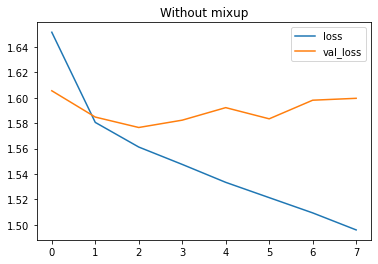

In [365]:
pd.DataFrame(history_org.history)[['loss','val_loss']].plot(title="Without mixup")

In [366]:
model = BasicModel()
history_mixup = model.fit(generator, steps_per_epoch=step,
                          epochs=epochs,
                          validation_data=(x_test, y_test))

Epoch 1/8
904/904 [==============================] - 3s 3ms/step - loss: 1.6970 - accuracy: 0.3182 - val_loss: 1.5991 - val_accuracy: 0.3624
Epoch 2/8
904/904 [==============================] - 3s 3ms/step - loss: 1.6331 - accuracy: 0.3418 - val_loss: 1.6161 - val_accuracy: 0.3488
Epoch 3/8
904/904 [==============================] - 3s 3ms/step - loss: 1.6174 - accuracy: 0.3512 - val_loss: 1.5906 - val_accuracy: 0.3651
Epoch 4/8
904/904 [==============================] - 3s 3ms/step - loss: 1.6115 - accuracy: 0.3592 - val_loss: 1.6110 - val_accuracy: 0.3402
Epoch 5/8
904/904 [==============================] - 3s 3ms/step - loss: 1.5971 - accuracy: 0.3694 - val_loss: 1.5809 - val_accuracy: 0.3700
Epoch 6/8
904/904 [==============================] - 3s 3ms/step - loss: 1.5885 - accuracy: 0.3734 - val_loss: 1.6072 - val_accuracy: 0.3592
Epoch 7/8
904/904 [==============================] - 3s 3ms/step - loss: 1.5863 - accuracy: 0.3718 - val_loss: 1.5921 - val_accuracy: 0.3594
Epoch 8/8
904

<AxesSubplot:title={'center':'With mixup'}>

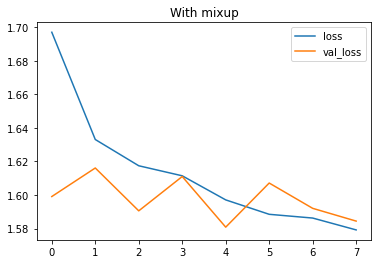

In [367]:
pd.DataFrame(history_mixup.history)[['loss','val_loss']].plot(title="With mixup")

# Understand Loss Graphs

#### As we can see above, mixup is doing great as regularizer. The loss curves are getting close for train and val sets.

# Plotting the Results of MIXUP

In [368]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=16)
    plt.yticks(tick_marks, classes, fontsize=16)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)

In [369]:
predicted_documents = model.predict(x_test, batch_size=batch_size)
y_pred =  np.argmax(predicted_documents, axis=1)
#y_pred = y_pred[:,1].reshape(686).flatten()  # use for pure cnn output

## Confusion Matrix

In [370]:
y_test = np.argmax(y_test, axis=1)

In [371]:
import itertools
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))

Confusion Matrix
[[327   0  43 113 129  13  39]
 [  8   8   2  18  37  30  66]
 [150   1 160  50  70  19  40]
 [123   2  31 484 214  69 178]
 [198   0  34 231 232  84 160]
 [ 36   2  13  78  82 217 231]
 [ 91   4  25 155 158 182 463]]


## Precision, Recall, Accuracy, F1

In [372]:
print('Precision: %.4f' % precision_score(y_test, y_pred, average="weighted"))
print('Recall: %.4f' % recall_score(y_test, y_pred, average="weighted"))
print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))
print('F1 Score: %.4f' % f1_score(y_test, y_pred, average="weighted"))

Precision: 0.3788
Recall: 0.3708
Accuracy: 0.3708
F1 Score: 0.3652


## Classification Report

In [373]:
df_c = pd.DataFrame(y_test)
value_counts = df_c.value_counts()
dictionary = dict()
for (i,), j in value_counts.items():
    dictionary[i] = j

dictionary

{3: 1101, 6: 1078, 4: 939, 0: 664, 5: 659, 2: 490, 1: 169}

In [376]:
target_names = ['happiness',
'hate',     
'love',
'neutral',
'other',
'sadness',
'worry']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   happiness       0.35      0.49      0.41       664
        hate       0.47      0.05      0.09       169
        love       0.52      0.33      0.40       490
     neutral       0.43      0.44      0.43      1101
       other       0.25      0.25      0.25       939
     sadness       0.35      0.33      0.34       659
       worry       0.39      0.43      0.41      1078

    accuracy                           0.37      5100
   macro avg       0.40      0.33      0.33      5100
weighted avg       0.38      0.37      0.37      5100

